# Comprehensive Exploratory Data Analysis: Step by Step

## Table of Contents
- [1 - Packages](#1)
- [2 - Data Overview](#2)
    - [2.1 - Load the Data](#2-1)
    - [2.2 - Basic Information](#2-2)
- [3 - Univariate Analysis](#3)
    - [3.1 - Categorical Variables](#3-1)
        - [`patients` data](#3-1-1)
                - [Transforming Static Features](#3-1-1-1)
        - [`interventions` data](#3-1-2)
    - [3.2 - Continuous Variables](#3-2)
        - [`patients` data](#3-2-1)
        - [`vitals_labs` data](#3-2-2)
- [4 - Handling Missing Data](#4)
    - [4.1 - Identifying Missing Data](#4-1)
    - [4.2 - Train/Dev/Test Split](#4-2)
    - [4.3 - Data Imputation](#4-3)
- [5 - Bivariate Analysis](#5)
    - [5.1 - Correlation Analysis](#5-1)
    - [5.2 - Visualizing Relationships](#5-2)
- [6 - Outlier Detection](#6)
    - [6.1 - Identifying Outliers](#6-1)
    - [6.2 - Handling Outliers](#6-2)
- [7 - Feature Engineering](#7)
    - [7.1 - Creating New Features](#7-1)
    - [7.2 - Transforming Features](#7-2)
- [8 - Preparing Data for Modeling](#8)
    - [8.1 - Data Encoding](#8-1)
    - [8.2 - Data Splitting](#8-2)

<a name='1'></a>
## 1 - Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import h5py

import os
# import wandb
import warnings

from config import *
from utils.eda_functions import *
from src.preprocessing.demographics import *
from src.preprocessing.vitals_labs import *
from src.preprocessing.split_dataset import *
from src.data_imputation.simple_impute import *
from src.data_imputation.hybrid_impute import hybrid_imputer
from utils.safe_display import blind_display

%load_ext autoreload
%autoreload 2

In [2]:
# Configuration & Settings:
plt.rcParams['figure.figsize'] = (12, 8)

warnings.filterwarnings('ignore')
# os.environ['WANDB_SILENT'] = 'true'
# sns.set_theme(style="whitegrid")

# # Login and initialize a new wandb run
# wandb_key = os.environ.get("WANDB_API_KEY")
# ! wandb login $wandb_key
#
# run = wandb.init(
#     project='FuzzyMedNet',
#     name='patient_eda',
#     job_type='eda'
# )

In [2]:
# Safety flag - when set to True will not display sensitive data
BLINDED = False

<a name='2'></a>
## 2 - Data Overview

<a name='2-1'></a>
### 2.1 - Loading the Data

In [3]:
%%time
with h5py.File(DATA_FILE_PATH, 'r') as file:
    # Print the keys at the root of the file
    print(list(file.keys()))

patients = pd.read_hdf(DATA_FILE_PATH, 'patients')
vitals_labs = pd.read_hdf(DATA_FILE_PATH, 'vitals_labs')
vitals_labs_mean = pd.read_hdf(DATA_FILE_PATH, 'vitals_labs_mean')
interventions = pd .read_hdf(DATA_FILE_PATH, 'interventions')
codes = pd.read_hdf(DATA_FILE_PATH, 'codes')

['codes', 'interventions', 'patients', 'vitals_labs', 'vitals_labs_mean']
CPU times: total: 42.5 s
Wall time: 57.4 s


<a name='2-2'></a>
### 2.2 - Basic Information

In [ ]:
vitals_labs[vitals_labs[('white blood cell count', 'mean')].notna()][('white blood cell count', 'mean')]

In [ ]:
print(f'patients.shape: {patients.shape}')
print(patients.info())

In [ ]:
print(f'vitals_labs_mean.shape: {vitals_labs_mean.shape}')
print(vitals_labs_mean.info())

In [ ]:
print(f'interventions.shape: {interventions.shape}')
print(interventions.info())

In [ ]:
# Limit vital signs, lab measurements, and interventions to the first 30 hours of admission
WINDOW_SIZE = 24
vitals_labs_24 = vitals_labs[vitals_labs.index.get_level_values('hours_in') < WINDOW_SIZE]
vitals_labs_mean_24 = vitals_labs_mean[vitals_labs_mean.index.get_level_values('hours_in') < WINDOW_SIZE]
interventions_24 = interventions[interventions.index.get_level_values('hours_in') < WINDOW_SIZE]
blind_display(patients, vitals_labs_mean, interventions, blinded=BLINDED)

<a name='3'></a>
## 3 - Univariate Analysis

<a name='3-1'></a>
### 3.1 - Categorical Variables

<a name='3-1-1'></a>
`patients` data

In [ ]:
patient_categorical_vars = ["gender", "insurance", "admission_type", "first_careunit"]
plot_categorical_columns(patients, patient_categorical_vars)

<a name='3-1-1-1'></a>
#### Transforming Static Features

In [ ]:
# group age
patients['age'] = patients['age'].apply(categorize_age)
patients['age'].value_counts(dropna=False)

In [ ]:
# check ethnicity categories
patients['ethnicity'].value_counts(dropna=False)

In [ ]:
# Regroup similar categories of ethnicities
patients['ethnicity'] = patients['ethnicity'].apply(categorize_ethnicity)
patients['ethnicity'].value_counts(dropna=False)

In [ ]:
# regroup admission types into: EMERGENCY & ELECTIVE
patients['admission_type'] = patients['admission_type'].apply(group_admission_type)
patients['admission_type'].value_counts(dropna=False)

<a name='3-1-2'></a>
`interventions` data

In [ ]:
inter_reset = interventions.reset_index()
inter_grouped = interventions.groupby(['hours_in']).sum().reset_index()
inter_grouped.set_index('hours_in', inplace=True)
inter_grouped

In [ ]:
plot_hourly_counts(df=inter_grouped, features=inter_grouped.columns)

<a name='3-2'></a>
### 3.2 - Continuous Variables

<a name='3-2-1'></a>
`patients` data

In [ ]:
# Calculate length of stay in ICU
patients['icu_stay_length'] = calculate_duration(patients, 'intime', 'outtime', 'h')  # in hours

# Plot distribution of times
time_columns = ['admittime', 'dischtime', 'intime', 'outtime']
plot_time_analysis(patients, time_columns)

In [ ]:
# Plot distribution of length of stay in ICU
plt.figure(figsize=(10,6))
sns.histplot(data=patients, x='los_icu', bins=50, kde=True)
plt.title('Length of Stay in ICU (in days)')
plt.xlabel('Duration (days)')
plt.ylabel('Frequency')
plt.show()

<a name='3-2-2'></a>
`vitals_labs` data
1. **Descriptive Statistics**
We'll start by calculating summary statistics for the DataFrame. This will help us understand the central tendency, spread, and shape of the distribution of the dataset.
<br></br>
2. **Time-Series Plots**
For selected vital signs and lab measurements, we'll plot time-series graphs.
<br></br>
3. **Distribution Plots**
We'll visualize the distribution of selected columns to understand their shape, center, and spread.

In [ ]:
vitals_labs_mean.describe()

In [ ]:
reset_df = vitals_labs.reset_index()
reduced_df = reset_df.groupby(['subject_id', 'hadm_id', 'icustay_id']).mean().reset_index()
reduced_df.drop(columns=['hours_in'], inplace=True)

melted_df = pd.melt(reduced_df, id_vars=['subject_id', 'hadm_id', 'icustay_id'], var_name=['LEVEL2', 'Aggregation Function'], value_name='Value')
melted_df.drop(columns = ['subject_id', 'hadm_id', 'icustay_id'], inplace=True)

vitals_summary = melted_df.groupby(['LEVEL2', 'Aggregation Function']).mean().reset_index()
vitals_summary = vitals_summary.pivot_table(index='LEVEL2', columns='Aggregation Function', values='Value')
vitals_summary.drop(columns=['count'], inplace=True)

vitals_missing = vitals_labs_mean.isnull().sum() / vitals_labs_mean.shape[0] * 100
vitals_missing = vitals_missing.reset_index()
vitals_missing.drop(columns=['Aggregation Function'], inplace=True)
vitals_missing.rename(columns={0: 'missing percent'}, inplace=True)

vitals_missing

In [ ]:
vitals_pivot = pd.merge(vitals_summary, vitals_missing, on=['LEVEL2'])
vitals_pivot.rename(columns={'LEVEL2': 'measurement'}, inplace=True)
vitals_pivot.sort_values(by='missing percent', ascending=True, inplace=True)
vitals_pivot.reset_index(drop=True, inplace=True)

vitals_ranges_df = pd.read_csv('../resources/vitals_labs_ranges.csv')
vitals_ranges_df.columns = vitals_ranges_df.columns.str.lower()

merged_vitals = pd.merge(vitals_pivot, vitals_ranges_df[['measurement', 'valid low', 'valid high']], on=['measurement'], how='left')
merged_vitals.to_csv('../resources/vitals_labs_stats.csv')
merged_vitals

#### Hourly Measurements Spread across first 30 hours - Vital Signs

In [ ]:
# Check at which hours is data most gathered
reset_df = vitals_labs_mean.reset_index()
hourly_vitals_df = reset_df.groupby(['hours_in']).count().reset_index()
hourly_vitals_df.drop(columns=['subject_id', 'hadm_id', 'icustay_id'], inplace=True)
hourly_vitals_df.columns = hourly_vitals_df.columns.droplevel(1)
hourly_vitals_df.set_index('hours_in', inplace=True)
hourly_vitals_df

In [ ]:
plot_hourly_counts(df=hourly_vitals_df, features=VITAL_SIGNS)

#### Hourly Measurements Spread across first 30 hours - Labs

In [ ]:
lab_features = list(merged_vitals[merged_vitals['missing percent'] < 95]['measurement'])
lab_features = [feat for feat in lab_features if feat not in VITAL_SIGNS]
lab_features

In [ ]:
plot_hourly_counts(df=hourly_vitals_df, features=lab_features)

<a name='4'></a>
## 4 - Data Pre-processing

<a name='4-1'></a>
### 4.1 - Identifying Missing Data

In the preceding examination, it was identified that missing data exists solely within the `vitals_labs` dataframe.

### Encoding full `patient` categorical data before splitting

In [ ]:
# Drop irrelevant or duplicated columns
columns_to_drop = ['admittime', 'dischtime', 'outtime', 'deathtime', 'discharge_location', 'dnr_first_charttime', 'diagnosis_at_admission', 'insurance', 'hospstay_seq', 'hospital_expire_flag', 'los_icu']

patients.drop(columns= columns_to_drop, inplace=True)

# Select columns to be one-hot encoded
categorical_cols = ['gender', 'age', 'ethnicity', 'admission_type', 'first_careunit']

patients_encoded = pd.get_dummies(patients, columns=categorical_cols)
patients_encoded.drop(columns=['gender_F', 'admission_type_ELECTIVE'], inplace=True)
patients_encoded.fillna(0, inplace=True)

patients_encoded.loc[:, 'intime'] = patients_encoded['intime'].astype('datetime64[ns]').apply(lambda x : x.hour)

blind_display(patients_encoded, blinded=BLINDED)

In [ ]:
%%time
datasets = train_test_dev_split(patients_encoded, vitals_labs, interventions)

In [ ]:
%%time
# Define keys and corresponding variable names
keys_varnames = [
    ('patients', 'patients_train', 'patients_dev', 'patients_test'),
    ('vitals', 'vitals_train', 'vitals_dev', 'vitals_test'),
    ('interv', 'interv_train', 'interv_dev', 'interv_test'),
    ('Ys', 'Ys_train', 'Ys_dev', 'Ys_test')
]

# Loop through each key and variable name to extract data and print shapes
for key, train_var, dev_var, test_var in keys_varnames:
    train_data, dev_data, test_data = datasets[key]
    print(f'\n{key.capitalize()}:')
    print(train_data.shape)
    print(dev_data.shape)
    print(test_data.shape)

    # log the datasets
    save_to_pickle(train_data, os.path.join(LOG_DATA_DIR, f'{train_var}_split.pkl'))
    save_to_pickle(dev_data, os.path.join(LOG_DATA_DIR, f'{dev_var}_split.pkl'))
    save_to_pickle(test_data, os.path.join(LOG_DATA_DIR, f'{test_var}_split.pkl'))

    # set the variables
    globals()[train_var], globals()[dev_var], globals()[test_var] = train_data, dev_data, test_data

<a name='4-3'></a>
### 4.3 Data Imputation
The strategy for handling the missing values in `vitals_labs` is as follows:

- Initial imputation employs **forward-filling** to propagate the last valid observation to succeeding `NaN` entries.

- Subsequently, any residual missing values within each `icustay_id` group are replaced by the **group's mean**.

- Finally, any remaining `NaN`s are filled with **zeros**.

- A binary mask is generated to indicate the presence of data.

- Time deltas are computed to represent the duration since the last available measurement for each column.

#### Simple Impute

In [ ]:
%%time
global_means, icustay_means = calculate_impute_values(vitals_train)

vitals_train_imputed, vitals_dev_imputed, vitals_test_imputed = [
    simple_imputer(df, global_means, icustay_means) for df in (vitals_train, vitals_dev, vitals_test)
]

# log the datasets
save_to_pickle(vitals_train_imputed, os.path.join(LOG_DATA_DIR, f'vitals_train_imputed.pkl'))
save_to_pickle(vitals_dev_imputed, os.path.join(LOG_DATA_DIR, f'vitals_dev_imputed.pkl'))
save_to_pickle(vitals_test_imputed, os.path.join(LOG_DATA_DIR, f'vitals_test_imputed.pkl'))

for df in vitals_train_imputed, vitals_dev_imputed, vitals_test_imputed: assert not df.isnull().any().any()

In [ ]:
vitals_train_imputed = load_from_pickle(os.path.join(DATA_DIR, 'vitals_train.pkl'))
vitals_dev_imputed = load_from_pickle(os.path.join(DATA_DIR, 'vitals_dev.pkl'))
vitals_test_imputed = load_from_pickle(os.path.join(DATA_DIR, 'vitals_test.pkl'))

#### Hybrid Impute

In [ ]:
%%time
global_means, icustay_means = calculate_impute_values(vitals_train)

vitals_train_imputed2, vitals_dev_imputed2, vitals_test_imputed2 = [
    hybrid_imputer(df, global_means, icustay_means) for df in (vitals_train, vitals_dev, vitals_test)
]
for df in vitals_train_imputed2, vitals_dev_imputed2, vitals_test_imputed2: assert not df.isnull().any().any()

In [ ]:
# Define keys and corresponding variable names
vitals_train_imputed2.to_csv('../data/processed_hybrid/vitals_train_hybrid.csv')
vitals_dev_imputed2.to_csv('../data/processed_hybrid/vitals_dev_hybrid.csv')
vitals_test_imputed2.to_csv('../data/processed_hybrid/vitals_test_hybrid.csv')

#### Data Standardization

In [ ]:
%%time
vitals_train_std, vitals_dev_std, vitals_test_std = standardize(vitals_train_imputed, vitals_dev_imputed, vitals_test_imputed)

In [ ]:
# log the datasets
save_to_pickle(vitals_train_std, os.path.join(DATA_DIR, f'Vitals_train_std.pkl'))
save_to_pickle(vitals_dev_std, os.path.join(DATA_DIR, f'Vitals_dev_std.pkl'))
save_to_pickle(vitals_test_std, os.path.join(DATA_DIR, f'Vitals_test_std.pkl'))

<a name='5'></a>
## 5 - Bivariate Analysis

In [ ]:
# For analysis purposes we will concatenate the splitted datasets
patients_full_imputed = pd.concat([patients_train, patients_dev, patients_test])
vitals_full_imputed = pd.concat([vitals_train_std, vitals_dev_std, vitals_test_std])
interv_full_imputed = pd.concat([interv_train, interv_dev, interv_test])
Ys_full_imputed = pd.concat([Ys_train, Ys_dev, Ys_test])
blind_display(patients_full_imputed, vitals_full_imputed, interv_full_imputed, Ys_full_imputed, blinded=BLINDED)

<a name='5-1'></a>
### 5.1 - Correlation Analysis

<a name='5-1-1'></a>
#### `patients` data - Correlation Among Features

In [ ]:
pearson_correlation_among_features(patients_full_imputed)

We will need to remove highly correlated predictor variables to avoid multi-collinearity.
Pairs such as: `dnr` - `dnr_first`, `cmo` - `cmo_first`, `max_hours` - `los_icu`, etc.

In [ ]:
# Extracting pairs without duplicates
corr_pairs_df = pearson_highly_correlated_pairs(patients_full_imputed)
corr_pairs_df

In [ ]:
highly_corr_drop = ['dnr', 'fullcode', 'cmo', 'cmo_last']
# patients_full_imputed.drop(columns=highly_corr_drop, inplace=True)
patients_train.drop(columns=highly_corr_drop, inplace=True)
patients_dev.drop(columns=highly_corr_drop, inplace=True)
patients_test.drop(columns=highly_corr_drop, inplace=True)

<a name='5-1-2'></a>
#### `patients` data - Feature vs Target Analysis

In [ ]:
pearson_target_correlation(patients_full_imputed, Ys_full_imputed)

In [ ]:
from sklearn.feature_selection import mutual_info_regression

mir_results = mutual_info_regression(patients_full_imputed, Ys_full_imputed['mort_hosp'], discrete_features=[i for i in range(patients_full_imputed.shape[1])], random_state=68)
mir_results

<a name='5-1-3'></a>
#### `vitals_labs` data - Correlation among Features

In [ ]:
# idx = pd.IndexSlice
# vitals_full_mean = vitals_full_imputed.loc[:, idx[:, ['mean']]]
cols_with_mean = [col for col in vitals_full_imputed.columns if col.endswith('_mean')]
vitals_full_mean = vitals_full_imputed[cols_with_mean]
pearson_highly_correlated_pairs(vitals_full_mean, threshold=.5)

Based on medical understanding and the Pearson correlation coefficients, the following variable pairs appear to be correlated and it makes sense from a physiological perspective:

1. **Alanine Aminotransferase & Aspartate Aminotransferase**: Both are liver enzymes.
   - **Keep**: Aspartate Aminotransferase, because it has less missing data.

2. **Alanine Aminotransferase & Lactate Dehydrogenase**: Both are enzymes but usually related to different organ systems (liver vs general tissue damage).
   - **Keep**: We removed Alanine Aminotransferase above.

3. **Aspartate Aminotransferase & Lactate Dehydrogenase**: Similar to the above point.
   - **Keep**: Both, as they offer different insights.

4. **Bicarbonate & CO2**: Both are related to acid-base balance.
   - **Keep**: Bicarbonate, it's more commonly used in clinical settings.

5. **Bicarbonate & CO2 (etCO2, pCO2, etc.)**: Again, related to acid-base balance.
   - **Keep**: Bicarbonate, as it's more common.

6. **Blood Urea Nitrogen & Creatinine**: Both are related to kidney function.
   - **Keep**: Creatinine, it's more sensitive to changes in kidney function.

7. **Cardiac Index & Cardiac Output Thermodilution**: Both are measures of cardiac function.
   - **Keep**: Cardiac Index, because it has less missing data.

8. **Cardiac Index & Systemic Vascular Resistance**: Inversely related; both are related to cardiovascular function.
   - **Keep**: Both, as they offer different insights.

9. **Cardiac Output Thermodilution & Systemic Vascular Resistance**: Similar to the above point.
   - **Keep**: We removed Cardiac Output above.

10. **Chloride & Sodium**: Both are electrolytes and often move in the same direction.
    - **Keep**: Sodium, more commonly used in clinical settings.

11. **Cholesterol & Cholesterol LDL**: LDL is a type of cholesterol.
    - **Keep**: Cholesterol, as it has less missing data

12. **CO2 & CO2 (etCO2, pCO2, etc.)**: Different measures of CO2.
    - **Keep**: Both removed.

13. **CO2 (etCO2, pCO2, etc.) & Partial Pressure of Carbon Dioxide**: Different measures of CO2.
    - **Keep**: Partial Pressure of Carbon Dioxide, more direct measure.

14. **Diastolic Blood Pressure & Mean Blood Pressure**: Both are blood pressure metrics.
    - **Keep**: Both.

15. **Diastolic Blood Pressure & Systolic Blood Pressure**: Both are blood pressure metrics.
    - **Keep**: Both.

16. **Hematocrit & Hemoglobin**: Both relate to red blood cells.
    - **Keep**: Hemoglobin, more directly related to oxygen-carrying capacity.

17. **Hematocrit & Red Blood Cell Count**: Both are measures of red blood cells.
    - **Keep**: We removed Hematocrit above.

18. **Hemoglobin & Red Blood Cell Count**: Both relate to red blood cells.
    - **Keep**: Hemoglobin, more directly related to oxygen-carrying capacity.

19. **Lactate & Lactic Acid**: Both are forms of the same substance.
    - **Keep**: Lactate, more commonly used to diagnose and monitor sepsis.

20. **Lymphocytes & Neutrophils**: Both are types of white blood cells but usually inversely related.
    - **Keep**: Both, as they provide different information.

21. **Mean Blood Pressure & Systolic Blood Pressure**: Both are measures of blood pressure.
    - **Keep**: Both.

22. **Mean Corpuscular Hemoglobin & Mean Corpuscular Volume**: Related to the size and content of red blood cells.
    - **Keep**: Mean Corpuscular Hemoglobin

23. **Peak Inspiratory Pressure & Plateau Pressure**: Related to mechanical ventilation settings.
    - **Keep**: Both

24. **Phosphate & Phosphorous**: Essentially the same, related to bone and cell function.
    - **Keep**: Phosphate, as it has less missing data.

25. **Positive End-Expiratory Pressure & Positive End-Expiratory Pressure Set**: Related to mechanical ventilation.
    - **Keep**: Positive End-Expiratory Pressure Set, as it has less missing data.

26. **Potassium & Potassium Serum**: Essentially the same thing.
    - **Keep**: Potassium, more commonly used.

27. **Prothrombin Time INR & Prothrombin Time PT**: Both are related to clotting.
    - **Keep**: INR, it's more standardized.

28. **Pulmonary Artery Pressure Mean & Pulmonary Artery Pressure Systolic**: Both relate to pulmonary artery pressure.
    - **Keep**: Both.

29. **Tidal Volume Observed & Tidal Volume Set**: Related to mechanical ventilation.
    - **Keep**: Tidal Volume Observed, as it has less missing data.

In [ ]:
vitals_to_drop = ['alanine aminotransferase', 'co2', 'co2 (etco2, pco2, etc.)', 'blood urea nitrogen', 'cardiac output thermodilution', 'chloride', 'cholesterol ldl', 'hematocrit', 'red blood cell count', 'lactic acid', 'mean corpuscular volume', 'phosphorous', 'positive end-expiratory pressure', 'potassium serum', 'prothrombin time pt', 'tidal volume set']

cols_to_drop = []
for vital in vitals_to_drop:
    cols_to_drop.append(f'{vital}_mask')
    cols_to_drop.append(f'{vital}_mean')
    cols_to_drop.append(f'{vital}_time_since_measured')

In [ ]:
# vitals_full_imputed.drop(columns=cols_to_drop,  inplace=True)
vitals_train_std.drop(columns=cols_to_drop, inplace=True)
vitals_dev_std.drop(columns=cols_to_drop, inplace=True)
vitals_test_std.drop(columns=cols_to_drop, inplace=True)

In [ ]:
def standardize_gpu(vitals_train, vitals_dev, vitals_test):
    idx = pd.IndexSlice
    X_train, X_dev, X_test = vitals_train.copy(), vitals_dev.copy(), vitals_test.copy()

    # Min-Max Scaling
    train_min = X_train.loc[:, idx[:, 'mean']].min()
    train_max = X_train.loc[:, idx[:, 'mean']].max()
    for df in [X_train, X_dev, X_test]:
        df.loc[:, idx[:, 'mean']] = minmax_scaling(df.loc[:, idx[:, 'mean']], train_min, train_max)

    # Standardization
    X_train.loc[:, idx[:, 'time_since_measured']] = np.where(X_train.loc[:, idx[:, 'time_since_measured']] == 100, 0,
                                                             X_train.loc[:, idx[:, 'time_since_measured']])
    train_mean = X_train.loc[:, idx[:, 'time_since_measured']].mean()
    train_std = X_train.loc[:, idx[:, 'time_since_measured']].std()
    for df in [X_train, X_dev, X_test]:
        df.loc[:, idx[:, 'time_since_measured']] = standardize_time_since_measured(
            df.loc[:, idx[:, 'time_since_measured']], train_mean, train_std)

    return X_train, X_dev, X_test

In [ ]:
%%time
vitals_train_gpu, vitals_dev_gpu, vitals_test_gpu = standardize_gpu(vitals_train_imputed, vitals_dev_imputed, vitals_test_imputed)

In [ ]:
# vitals_full_imputed.drop(columns=cols_to_drop,  inplace=True)
vitals_train_gpu.drop(columns=vitals_to_drop, inplace=True)
vitals_dev_gpu.drop(columns=vitals_to_drop, inplace=True)
vitals_test_gpu.drop(columns=vitals_to_drop, inplace=True)

#### `vitals_labs` Feature vs. Target Analysis

In [ ]:
cols_with_mean = [col for col in vitals_full_imputed.columns if col.endswith('_mean')]
vitals_full_mean = vitals_full_imputed[cols_with_mean]

In [ ]:
vitals_labs_mean_flat = vitals_labs_mean_24.copy()
vitals_labs_mean_flat.columns = vitals_labs_mean_flat.columns.droplevel(1)
vitals_labs_mean_flat

In [8]:
y_hosp = patients[['mort_hosp', 'mort_icu']]
vitals_labs_mean_flat = vitals_labs_mean_24.index.droplevel(0)

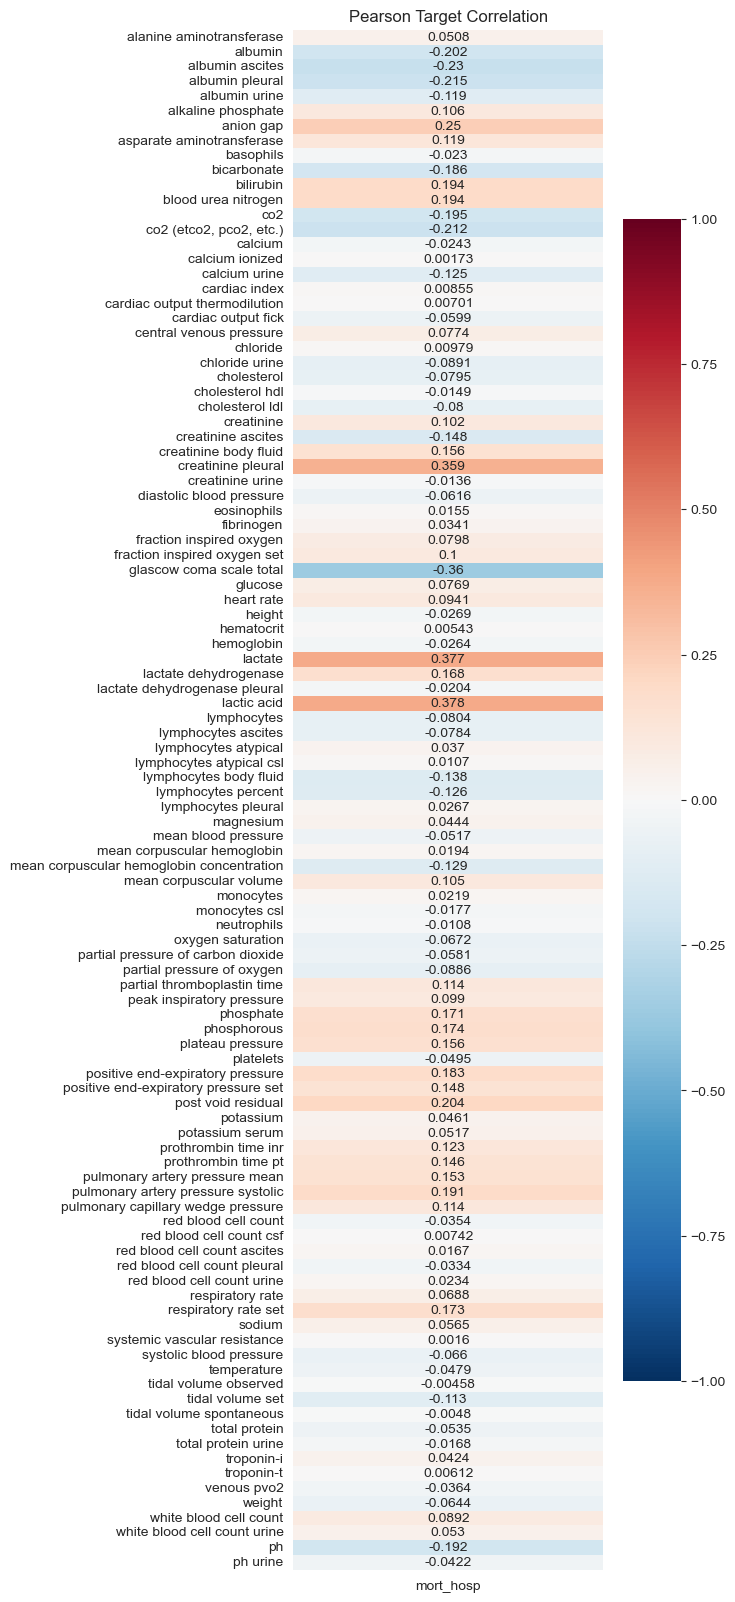

In [14]:
pearson_target_correlation(vitals_labs_mean_flat, y_hosp, fig_size=(5, 20))

In [15]:
X_y = pd.merge(vitals_labs_mean_flat, y_hosp[['mort_hosp']], left_index=True, right_index=True, how='left')
corr_matrix = X_y.corr()
corr_target = corr_matrix[['mort_hosp']].drop(labels=['mort_hosp'])

In [28]:
threshold = 0.15
corr_values = {}

for i, value in enumerate(corr_target['mort_hosp']):
    if np.abs(value) >= threshold:
        corr_values[corr_target.index[i]] = value
for i in range(corr_target.shape[0]):

    for j in range(corr_target.shape[1]):
        if np.abs(corr_target.iloc[i, j]) >= threshold and (cols[i], cols[j]) not in pairs_to_drop:
            corr_values.append([cols[i], cols[j], corr.iloc[i, j]])

corr_df = pd.DataFrame(corr_values, columns=['var1', 'var2', 'corr_value'])
corr_values

{'albumin': -0.2017828214001728,
 'albumin ascites': -0.22955395263052647,
 'albumin pleural': -0.21473430940908972,
 'anion gap': 0.24997697106891964,
 'bicarbonate': -0.18608956128959744,
 'bilirubin': 0.1938745475983378,
 'blood urea nitrogen': 0.19426597511584945,
 'co2': -0.19455676832535873,
 'co2 (etco2, pco2, etc.)': -0.21227178905365543,
 'creatinine body fluid': 0.15593526880411498,
 'creatinine pleural': 0.359038402713507,
 'glascow coma scale total': -0.3604592127404281,
 'lactate': 0.37701832509200894,
 'lactate dehydrogenase': 0.16792425698932364,
 'lactic acid': 0.3779457772414411,
 'phosphate': 0.17136333025767056,
 'phosphorous': 0.1743629074524624,
 'plateau pressure': 0.15632646433003902,
 'positive end-expiratory pressure': 0.18305753730876415,
 'post void residual': 0.20440594559998715,
 'pulmonary artery pressure mean': 0.15334286604135275,
 'pulmonary artery pressure systolic': 0.19061564484572463,
 'respiratory rate set': 0.17310151020628514,
 'ph': -0.192409877

In [32]:
common_vitals = pd.read_csv('../resources/common_vitals_labs.csv')
common_vitals

,measurement,normal min,normal high,risk min,risk high,unit of measurement
0,heart rate,60.00,100.00,0,100.00,bpm
1,respiratory rate,12.00,16.00,0,20.00,breaths per minute
2,systolic blood pressure,90.00,120.00,0,140.00,mmHg
3,diastolic blood pressure,60.00,80.00,0,90.00,mmHg
4,mean blood pressure,70.00,100.00,0,110.00,mmHg
5,oxygen saturation,95.00,100.00,0,90.00,%
6,temperature,36.10,37.20,0,37.50,°C
7,glucose,70.00,100.00,0,200.00,mg/dL
8,central venous pressure,2.00,6.00,0,6.00,mmHg
9,glasgow coma scale total,13.00,15.00,0,13.00,NaN


In [36]:
for key in corr_values.keys():
    if key not in common_vitals['measurement'].values:
        print(key)

albumin
albumin ascites
albumin pleural
bilirubin
co2 (etco2, pco2, etc.)
creatinine body fluid
creatinine pleural
glascow coma scale total
lactate
lactate dehydrogenase
lactic acid
plateau pressure
positive end-expiratory pressure
post void residual
pulmonary artery pressure mean
respiratory rate set


#### `interventions` data - Correlation among Features

In [ ]:
pearson_correlation_among_features(interv_full_imputed)

#### `interventions` data - Target vs Feature Correlation

In [ ]:
pearson_target_correlation(interv_full_imputed, Ys_full_imputed)

<a name='5-2'></a>
### 5.2 - Visualizing Relationships

### Create Feature Matrix

In [ ]:
X_train_merged = create_feature_matrix(patients_train, vitals_train_std, interv_train)
X_dev_merged = create_feature_matrix(patients_dev, vitals_dev_std, interv_dev)
X_test_merged = create_feature_matrix(patients_test, vitals_test_std, interv_test)
blind_display(X_train_merged, X_dev_merged, X_test_merged, blinded=BLINDED)

### Store Processed Data

In [ ]:
save_to_pickle(df=X_train_merged, filename=os.path.join(DATA_DIR, 'X_train.pkl'))
save_to_pickle(df=X_dev_merged, filename=os.path.join(DATA_DIR, 'X_dev.pkl'))
save_to_pickle(df=X_test_merged, filename=os.path.join(DATA_DIR, 'X_test.pkl'))

save_to_pickle(df=vitals_train_gpu, filename=os.path.join(DATA_DIR, 'Vitals_train.pkl'))
save_to_pickle(df=vitals_dev_gpu, filename=os.path.join(DATA_DIR, 'Vitals_dev.pkl'))
save_to_pickle(df=vitals_test_gpu, filename=os.path.join(DATA_DIR, 'Vitals_test.pkl'))

# save_to_pickle(df=Ys_train, filename=os.path.join(DATA_DIR, 'Y_train_24.pkl'))
# save_to_pickle(df=Ys_dev, filename=os.path.join(DATA_DIR, 'Y_dev_24.pkl'))
# save_to_pickle(df=Ys_test, filename=os.path.join(DATA_DIR, 'Y_test_24.pkl'))

In [ ]:
save_to_pickle(df=Ys_train, filename=os.path.join(DATA_DIR, 'Y_train_24.pkl'))
save_to_pickle(df=Ys_dev, filename=os.path.join(DATA_DIR, 'Y_dev_24.pkl'))
save_to_pickle(df=Ys_test, filename=os.path.join(DATA_DIR, 'Y_test_24.pkl'))